## Goal: What are Fst scores per exon + ss (+-2bp)
For exons that are 
* unique to one population or the other
* shared between the population
* this is on the exon level~!

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [6]:
df = pd.read_csv(proc_cfg(config['lr']['exons_ss_in_pops_fsts_summary'], od),
                 sep='\t')
df.rename({'ThickStart':'eid',
           'ThickEnd':'novelty',
           'ItemRGB':'pop1_det',
           'BlockCount':'pop2_det'}, 
          axis=1, inplace=True)

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

# since this is biallelic snp level, remove all exons that didnt intersect
print(len(df.index))
df = df.loc[df.End_b!=-1]
print(len(df.index))


1459932
177874


In [7]:
gb_cols = ['eid', 'novelty', 'pop1_det', 'pop2_det',
            'pop1', 'pop2']
keep_cols = gb_cols+['fst']


# make sure there are no dupe eid + contrast + var. posiition
# assert len(df[gb_cols+['End_b', 'Start_b']].drop_duplicates().index) == len(df.index) # oop there's a bug somewhere upstream w/ the vcf processing

print('REMOVE ME WHEN FABIEN FIXES FST STUFF')
print(len(df.index))
df = df.drop_duplicates(subset=gb_cols+['End_b', 'Start_b'], keep=False)
print(len(df.index))
df.head()

REMOVE ME WHEN FABIEN FIXES FST STUFF
177874
176872


,Chromosome,Start,End,Name,Score,Strand,eid,novelty,pop1_det,pop2_det,End_b,fst,Start_b,pop1,pop2
190,chr1,100007033,100007156,.,.,+,chr1_+_100007033_100007156,Known,True,True,100007048,0.476177,100007047,PEL,YRI
191,chr1,100043072,100043229,.,.,+,chr1_+_100043072_100043229,Known,False,True,100043099,0.045575,100043098,PEL,YRI
192,chr1,100043072,100043229,.,.,+,chr1_+_100043072_100043229,Known,False,True,100043213,0.000000,100043212,PEL,YRI
193,chr1,100049908,100050004,.,.,+,chr1_+_100049908_100050004,Known,True,True,100049941,0.021949,100049940,PEL,YRI
194,chr1,100140407,100141019,.,.,+,chr1_+_100140407_100141019,Known,True,True,100140797,0.051645,100140796,PEL,YRI


PEL vs YRI
0.00847616
0.00738377

LWK vs YRI
0.00126156
0.00169174

LWK vs PEL
0.012414
0.012414

ITU vs YRI
0.00872449
0.00872449

ITU vs PEL
0.00343865
0.00334283

ITU vs LWK
0.0109964
0.00925482

CEU vs YRI
0.00851363
0.00851363

CEU vs PEL
0.00601428
0.00601428

CEU vs LWK
0.0102731
0.0102731

CEU vs ITU
0.00300393
0.00300393



[Text(0.5, 15.0, 'Population 2'),
 Text(33.0, 0.5, 'Popluation 1'),
 Text(0.5, 1.0, 'Fsts of exonic, biallelic SNPs based on\n exon detection')]

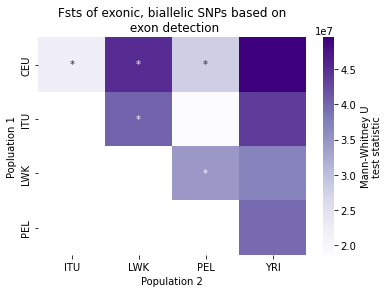

In [14]:
# loop through each contrast
stat_df = pd.DataFrame()
for pop1, pop2 in zip(df[['pop1', 'pop2']].drop_duplicates()['pop1'].tolist(),
                      df[['pop1', 'pop2']].drop_duplicates()['pop2'].tolist()):
    temp = df.loc[(df.pop1==pop1)&(df.pop2==pop2)]
    temp.rename({'pop1_det':pop1,
             'pop2_det':pop2}, axis=1, inplace=True)

    temp['med_per_group'] = temp.groupby([pop1, pop2])['fst'].transform('median')
    temp['mean_per_group'] = temp.groupby([pop1, pop2])['fst'].transform('mean')

    # print(temp[[pop1, pop2, 'med_per_group']].drop_duplicates())
    # print(temp[[pop1, pop2, 'mean_per_group']].drop_duplicates())

    temp['thing'] = ''
    temp.loc[(temp[pop1]==True)&(temp[pop2]==True), 'thing'] = f'{pop1}_{pop2}'
    temp.loc[(temp[pop1]==True)&(temp[pop2]==False), 'thing'] = f'{pop1}'
    temp.loc[(temp[pop1]==False)&(temp[pop2]==True), 'thing'] = f'{pop2}'     

    temp['thing2'] = 'unique'
    temp.loc[(temp[pop1]==True)&(temp[pop2]==True), 'thing2'] = 'shared'
    
    x = temp.loc[temp.thing2=='unique','fst'].tolist() # hyp. --> greater
    y = temp.loc[temp.thing2=='shared','fst'].tolist()
    
    print(f'{pop1} vs {pop2}')
    print(temp.loc[temp.thing2=='unique','fst'].median())
    print(temp.loc[temp.thing2=='shared','fst'].median())
    print()

    stat, pval = st.mannwhitneyu(x, y, alternative='greater')
    temp3 = pd.DataFrame(data=[[pop1, pop2, stat, pval]], 
                         columns=['pop1', 'pop2', 'stat', 'pval'])
    stat_df = pd.concat([stat_df, temp3], axis=0)

# fdr correction
from statsmodels.stats.multitest import multipletests
_, adj_p_vals, _, _ = multipletests(stat_df.pval.tolist(), method='fdr_bh')
stat_df['adj_pval'] = adj_p_vals
stat_df.head()

# add sig. annotation
# * <= 0.05
# ** <= 0.01
# *** <= 0.001
stat_df['sig_annot'] = ''
# stat_df.loc[stat_df.pval <= 0.05, 'sig_annot'] = '*'
# stat_df.loc[stat_df.pval <= 0.01, 'sig_annot'] = '**'
# stat_df.loc[stat_df.pval <= 0.001, 'sig_annot'] = '***'
stat_df.loc[stat_df.adj_pval <= 0.05, 'sig_annot'] = '*'
stat_df.loc[stat_df.adj_pval <= 0.01, 'sig_annot'] = '**'
stat_df.loc[stat_df.adj_pval <= 0.001, 'sig_annot'] = '***'

# pivot x2 to get a stat and annot df to plot
stat_df1 = stat_df.pivot(index='pop1', columns='pop2', values='stat')
annot_df = stat_df.pivot(index='pop1', columns='pop2', values='sig_annot')

ax = sns.heatmap(stat_df1, cmap='Purples',
            annot=annot_df,
            fmt='',
            cbar_kws={'label': 'Mann-Whitney U\ntest statistic'})

# labels need them
ax.set(xlabel='Population 2',
       ylabel='Popluation 1',
       title='Fsts of exonic, biallelic SNPs based on\n exon detection')